## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

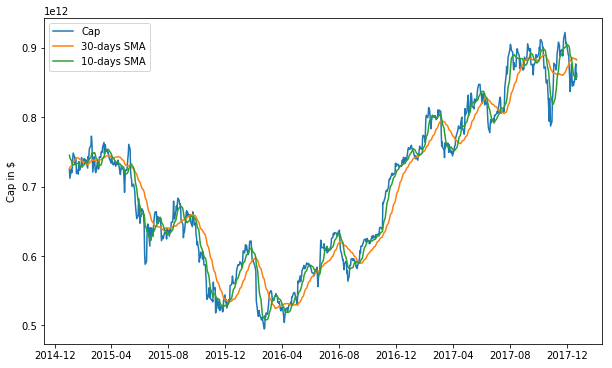

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$

Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


## Manipulate raw data

In [7]:
#mean() will then take the mean average of all the ticker symbol 
average_market_cap = df_cap.sum(axis=1).mean()
print(average_market_cap)

4.82787064071e+12


In [8]:
# Average
short_rolling_average = short_rolling / average_market_cap
long_rolling_average = long_rolling / average_market_cap
df_cap_average = df_cap / average_market_cap


In [9]:
print(short_rolling_average)

                AAPL       AXP        BA       CAT      CSCO       CVX  \
date                                                                     
2010-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-11       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-12       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-13       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-14       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-15  0.039502  0.010293  0.009069  0.007843  0.029271  0.033119   
2010-01-18  0.039526  0.010343  0.009137  0.007874  0.029290  0.033145   
2010-01-19  0.039481  0.010396  0.0091

In [10]:
print(long_rolling_average)

                AAPL       AXP        BA       CAT      CSCO       CVX  \
date                                                                     
2010-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-11       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-12       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-13       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-14       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-15       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-18       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-19       NaN       NaN       N

In [11]:
print(df_cap_average)

                AAPL       AXP        BA       CAT      CSCO       CVX  \
date                                                                     
2010-01-04  0.040132  0.010079  0.008455  0.007552  0.029419  0.032854   
2010-01-05  0.040202  0.010057  0.008732  0.007642  0.029288  0.033087   
2010-01-06  0.039562  0.010220  0.008997  0.007666  0.029097  0.033091   
2010-01-07  0.039489  0.010340  0.009361  0.007697  0.029228  0.032966   
2010-01-08  0.039752  0.010333  0.009271  0.007783  0.029383  0.033025   
2010-01-11  0.039401  0.010215  0.009161  0.008272  0.029300  0.033610   
2010-01-12  0.038953  0.010350  0.009095  0.008028  0.028835  0.033415   
2010-01-13  0.039547  0.010382  0.009205  0.008040  0.029359  0.033162   
2010-01-14  0.039318  0.010513  0.009265  0.007995  0.029729  0.033058   
2010-01-15  0.038661  0.010441  0.009153  0.007755  0.029073  0.032925   
2010-01-18  0.040372  0.010582  0.009128  0.007859  0.029610  0.033112   
2010-01-19  0.039749  0.010587  0.0090

In [12]:
short_rolling_average_first_valid = (short_rolling_average / short_rolling_average.loc[ short_rolling_average.first_valid_index() ])
long_rolling_average_first_valid = (long_rolling_average / long_rolling_average.loc[ long_rolling_average.first_valid_index() ])

In [13]:
short_rolling_demeaned = short_rolling_average_first_valid.pct_change(periods=1).shift(-1)
long_rolling_demeaned = long_rolling_average_first_valid.pct_change(periods=1).shift(-1)

In [14]:
type( short_rolling_average )

pandas.core.frame.DataFrame

In [15]:
short_rolling_average.head(10)

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
short_rolling_average.sample(10, random_state = 42 )

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2015-03-27,0.155711,0.016836,0.020392,0.010817,0.030626,0.040037,0.038816,0.012412,0.057249,0.018610,...,0.014484,0.043833,0.044266,0.006679,0.023389,0.021665,0.027958,0.041424,0.049868,0.073700
2011-08-17,0.073099,0.011969,0.009774,0.011581,0.017641,0.040420,0.012588,0.006652,0.034676,0.011629,...,0.006679,0.029988,0.035852,0.004286,0.010293,0.013554,0.009303,0.021065,0.037903,0.073562
2012-01-26,0.096662,0.012602,0.011644,0.015244,0.022423,0.043946,0.015408,0.008374,0.041790,0.011710,...,0.008093,0.033761,0.036730,0.004982,0.011741,0.015734,0.012364,0.022327,0.043586,0.084561
2010-02-12,0.037010,0.009410,0.009216,0.006927,0.028095,0.029843,0.012037,0.006488,0.035201,0.016415,...,0.005164,0.030203,0.037255,0.005413,0.007872,0.012941,0.008153,0.017002,0.042076,0.064080
2017-05-25,0.171094,0.015650,0.029110,0.014077,0.032310,0.042006,0.032592,0.016281,0.043893,0.017781,...,0.014691,0.040875,0.048808,0.007194,0.038880,0.019251,0.039142,0.040777,0.049390,0.067113
2016-09-14,0.122498,0.013808,0.019521,0.011569,0.030890,0.044150,0.033163,0.013004,0.057349,0.018698,...,0.014132,0.039678,0.046040,0.006826,0.031218,0.018479,0.030129,0.042707,0.045050,0.075101
2010-06-04,0.048025,0.009793,0.009886,0.007690,0.027341,0.030254,0.013692,0.006205,0.035248,0.015026,...,0.005872,0.024940,0.036607,0.005048,0.007079,0.012724,0.007488,0.016138,0.039431,0.058716
2012-08-31,0.131428,0.013452,0.010878,0.011884,0.020710,0.047623,0.019468,0.007334,0.049358,0.011504,...,0.007195,0.038467,0.039619,0.005469,0.011997,0.014938,0.014747,0.026985,0.051674,0.087652
2012-04-20,0.107725,0.013905,0.011321,0.012640,0.019282,0.041505,0.016572,0.007735,0.041513,0.010471,...,0.008207,0.035061,0.036265,0.005151,0.011833,0.014379,0.012781,0.024054,0.042094,0.080122


## Clean data

In [17]:
# Drop last row
market_cap = df_cap_average[:-1]

In [18]:
# Drop NaN Values
signal_1 = short_rolling_demeaned.copy()
signal_2 = long_rolling_demeaned.copy()

In [19]:
signal_1 = signal_1.dropna()
signal_2 = signal_2.dropna()

In [20]:
# Get rid rows where dates that do not match
market_cap = market_cap[ market_cap.index.isin(signal_1.index) & market_cap.index.isin(signal_2.index)]
signal_1 = signal_1[signal_1.index.isin( market_cap.index )]
signal_2 = signal_2[signal_2.index.isin( market_cap.index )]

In [27]:
# Get the amount of time steps
# Get the amount of time steps
time = market_cap.shape[0]
time

2050

In [28]:
# Get the number of stocks
n = market_cap.shape[1]
n

30

## TensorFlow 

In [29]:
start_date = '2010-1-1'
end_date = '2017-12-31'

# Only get the dates required
market_cap_focused = market_cap.loc[ start_date : end_date ]
signal_1_focused = signal_1.loc[ start_date : end_date ]
signal_2_focused = signal_2.loc[ start_date : end_date ]

# Mentioned in the instructions, 2 signals means k = 2
k = 2

In [30]:
# Creating a Pandas Dataframe to hold the results
results = pd.DataFrame( [], index = market_cap_focused.columns, columns = [ 'kappa', 'sigma', 'sigma^2', 'w1', 'w2'] )

In [33]:
# Tensorflow graph
tf.reset_default_graph()

# Input
x = tf.placeholder( shape = (None, n), dtype = tf.float32, name = 'x' )

# Signals
z1  = tf.placeholder( shape = (None,n), dtype = tf.float32, name = 'z1' ) 
z2  = tf.placeholder( shape = ( None, n), dtype=tf.float32, name = 'z2' )

# Variables
N_k = n
N_s = n
N_w = n

kappa = tf.get_variable( "kappa", initializer = tf.random_uniform([N_k], minval = 0.0, maxval = 1.0) )
sigma = tf.get_variable( "sigma", initializer = tf.random_uniform([N_s], minval=0.0, maxval=0.1) )

In [34]:
# Weights
#-------------------
w1_init = tf.random_normal( [N_w], mean=0.5, stddev=0.1 )
w2_init = 1 - w1_init

w1 = tf.get_variable( "w1", initializer = w1_init)
w2 = tf.get_variable( "w2", initializer = w2_init )

W1 = w1 * tf.ones(n)
W2 = w2 * tf.ones(n)

# Gaussian
#-------------------
mu    = tf.zeros( [n] )
Sigma = sigma * tf.ones( [n] )
theta1 = tf.multiply( W1, z1)
theta2 = tf.multiply( W2, z2)
scale  = tf.slice( x, [0,0], [1,-1] )
theta  = tf.multiply( scale, tf.cumprod( 1 + tf.add( theta1, theta2) ) )

Kappa = kappa * tf.ones( [n] )

r = tf.divide( tf.subtract( tf.manip.roll( x, shift = -1, axis = 0), x), x)
v = tf.subtract( r, tf.multiply( Kappa, tf.subtract( theta, x) ) )
# NOTE: Do not use last row
vuse = tf.slice( v, [0,0], [tf.shape(v)[0]-1,-1] )

#  Constraint - No negative
#-------------------
clip_w1 = w1.assign(tf.maximum(0., w1))
clip_w2 = w2.assign(tf.maximum(0., w2))
clip = tf.group(clip_w1, clip_w2)

dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
log_prob = dist.log_prob(vuse)
reg_term = tf.reduce_sum(tf.square(w1+w2-1))
neg_log_likelihood = -tf.reduce_sum(log_prob) + 0.01*reg_term


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [35]:
# Optimizer
#-------------------
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize( neg_log_likelihood )

In [36]:
max_iteration = 5000
tolerence = 1e-15

In [37]:
# Save Tensorflow model because running the weight
saver = tf.train.Saver()

# Run Tensorflow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    losses = sess.run([neg_log_likelihood], feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
    i=1
    
    # Calibrate print out
    print( "------------------- Calibration Calculating ----------------------" )
    print(" iter |       Loss       |   difference")
    
    while True:

        sess.run(train_op, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
        sess.run(clip) # force weights to be non-negative

        # update loss
        new_loss = sess.run(neg_log_likelihood, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
        loss_diff = np.abs(new_loss - losses[-1])
        losses.append(new_loss)

        if i%min(1000,(max_iteration/20))==1:
            print ("{:5} | {:16.4f} | {:12.4f}".format(i,new_loss,loss_diff))

        if loss_diff < tolerence:
            print('Loss function convergence in {} iterations!'.format(i))
            print('Old loss: {}  New loss: {}'.format(losses[-2],losses[-1]))
            break

        if i >= max_iteration:
            print('Max number of iterations reached without convergence.')
            break

        i += 1
    # Put data in pandas Dataframe.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)

    fitted_means = sess.run(theta, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
    mean_levels = pd.DataFrame(fitted_means,index=market_cap_focused.index,columns=market_cap_focused.columns)
    

------------------- Calibration Calculating ----------------------
 iter |       Loss       |   difference
    1 |       31866.0781 |   24900.8672
  251 |     -153628.0781 |      94.0625
  501 |     -174765.4062 |      56.8281
  751 |     -177322.7656 |       1.8750
 1001 |     -177647.4219 |       0.8750
 1251 |     -177810.1406 |       0.4844
 1501 |     -177900.4531 |       0.3125
 1751 |     -177954.3438 |       0.1562
 2001 |     -177988.5000 |       0.1562
 2251 |     -178011.3906 |       0.0938
Loss function convergence in 2297 iterations!
Old loss: -178014.78125  New loss: -178014.78125


In [40]:
    print( "------------------- Calibration Results ----------------------" )
    print(results.round(4))
    
    


------------------- Calibration Results ----------------------
       kappa   sigma  sigma^2      w1      w2
AAPL  0.6832  0.0158   0.0003  0.6303  0.3591
AXP   0.9632  0.0146   0.0002  0.8037  0.1382
BA    0.5523  0.0149   0.0002  0.6050  0.4243
CAT   1.1891  0.0166   0.0003  0.7516  0.1977
CSCO  1.2934  0.0160   0.0003  0.6881  0.2796
CVX   0.4778  0.0134   0.0002  0.7482  0.2283
DIS   1.0537  0.0135   0.0002  0.7410  0.2503
DWDP  0.2774  0.0274   0.0007  0.7325  0.3539
GE    0.5966  0.0140   0.0002  0.6751  0.3103
GS    0.6662  0.0167   0.0003  0.2919  0.4852
HD    0.5308  0.0126   0.0002  0.8319  0.1717
IBM   0.8200  0.0123   0.0002  0.7051  0.2555
INTC  0.6817  0.0148   0.0002  0.6343  0.3197
JNJ   0.9078  0.0097   0.0001  0.6779  0.3200
JPM   1.2495  0.0163   0.0003  0.7820  0.2109
KO    1.0806  0.0091   0.0001  0.4599  0.5301
MCD   0.9976  0.0096   0.0001  0.7016  0.3071
MMM   0.2706  0.0115   0.0001  0.4052  0.6790
MRK   0.3832  0.0122   0.0001  0.6717  0.2828
MSFT  0.3116  0.0

In [41]:
# Save the dataframe
results.to_csv('df_results_part01.csv')
results.to_csv('df_mean_levels_part01.csv')

In [42]:
data = df_cap
theta = mean_levels
start_date='2010-01-01'
end_date='2017-12-31'
nplot = 30
scale = 1
title = 'Market Cap '

avg_mkt_cap = data.sum(axis=1).mean() # average market cap over the period

N = data.shape[1]


if N > nplot: N = nplot

plt.figure(figsize=(15,N))
plt.suptitle(title + ' vs fitted mean reversion level',size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = data.columns[:N]
for index, stock in enumerate(stocks, 1):
    plt.subplot(np.ceil(N / 3), 3,index)
    plt.plot(scale * (1/1e9) * data.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot(scale * (avg_mkt_cap / 1e9) * theta.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

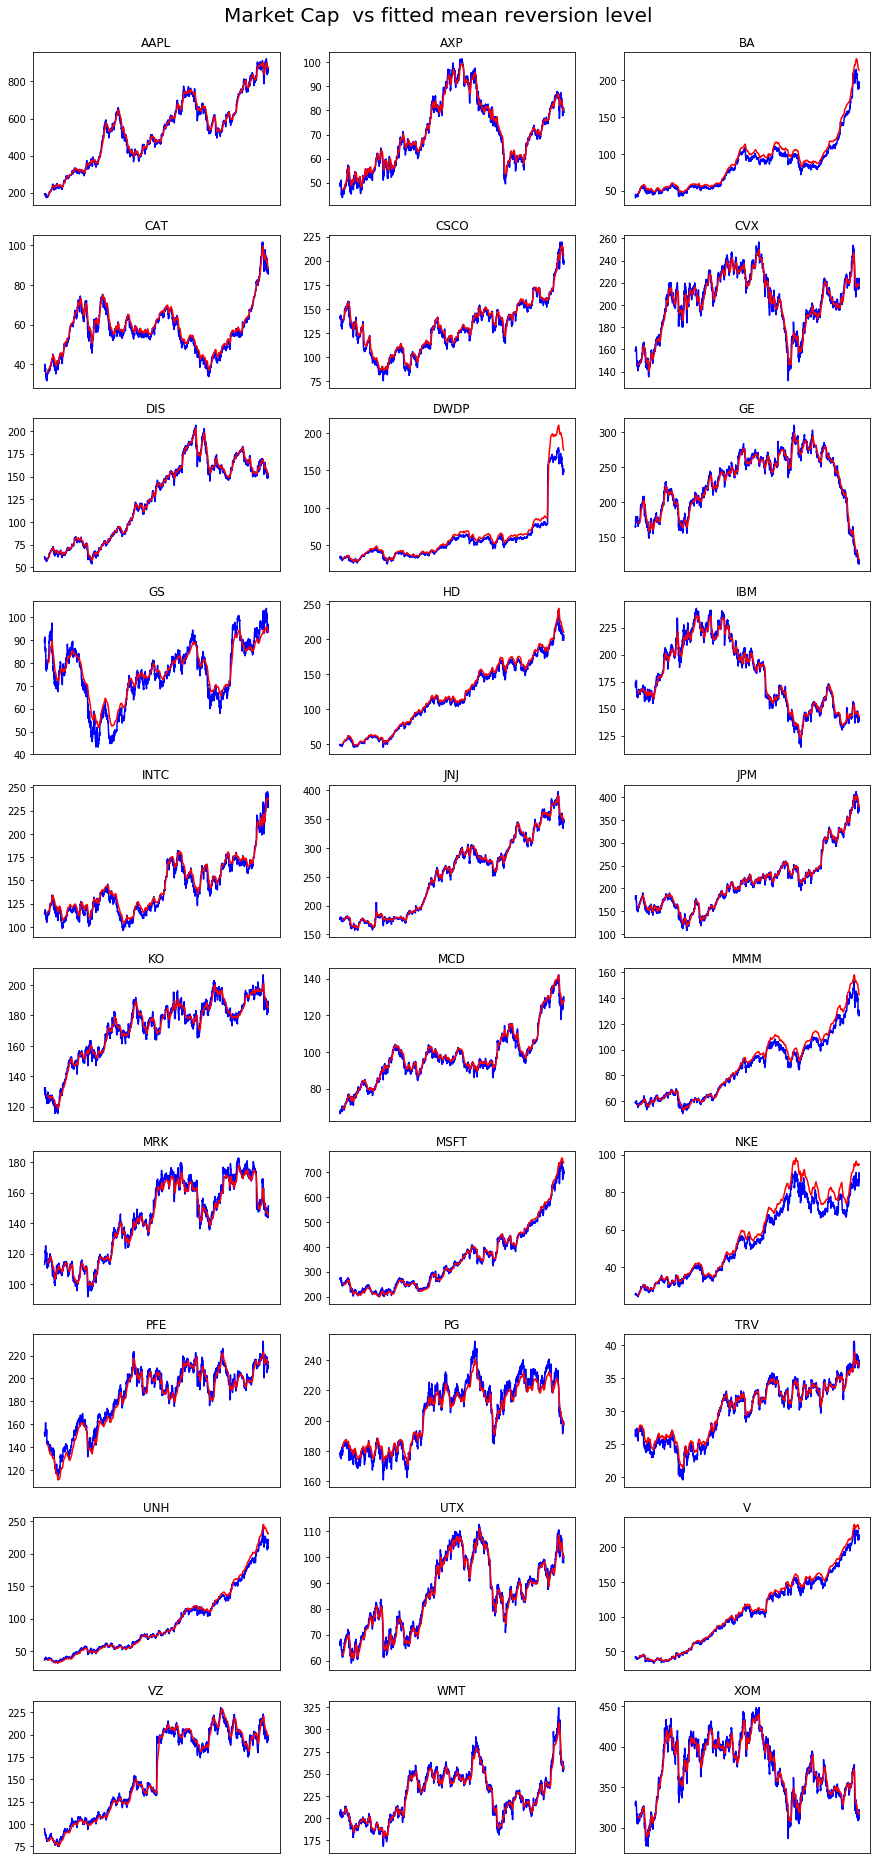

In [43]:
plt.show()

## Part 2: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


In [48]:
import datetime as dt
start_date = dt.date(2010, 2, 15)
end_date = dt.date(2017, 12, 22)

norm_data_fn =  lambda dataframe:  (dataframe)/df_cap.sum(axis=1).mean()

# Getting next step and drop the last row
dataframe_to_seek = df_cap.loc[ start_date : end_date ].iloc[:-1,:]
next_value = df_cap.loc[ start_date : end_date ].shift(-1).iloc[:-1,:]
z_1 = norm_data_fn(short_rolling).pct_change(periods=1).loc[ start_date : end_date ].iloc[:-1,:]
z_2 = norm_data_fn(long_rolling).pct_change(periods=1).loc[ start_date : end_date ].iloc[:-1,:]
z_1.columns  = ["z1_{}".format(x) for x in df_cap.columns]
z_2.columns  = ["z2_{}".format(x) for x in df_cap.columns]
Z = pd.merge(z_1, z_2, left_index=True, right_index=True)

X = norm_data_fn(dataframe_to_seek)
X_next = norm_data_fn(next_value)


In [49]:

from scipy.stats import linregress

def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, _, r_value, _, _ = linregress(x,y)
    return slope

window_1 = 10

short_rolling_regre = df_cap.rolling(window=window_1).apply(get_slope)
window_2 = 30

long_rolling_regre = df_cap.rolling(window=window_2).apply(get_slope)

In [50]:
# Put the rest of your code and analysis for Part 2 here.
import datetime as dt
start_date = dt.date(2010, 2, 15)
end_date = dt.date(2017, 12, 22)



norm_data_fn =  lambda dataframe:  (dataframe)/df_cap.sum(axis=1).mean()
norm_regre_fn = lambda dataframe: (dataframe - dataframe.mean())/dataframe.std()
zp_1 = norm_regre_fn(short_rolling_regre).loc[ start_date : end_date ].iloc[:-1,:]
zp_2 = norm_regre_fn(long_rolling_regre).loc[ start_date : end_date ].iloc[:-1,:]
X_next = norm_data_fn(next_value)

Zp = pd.merge(zp_1, zp_2, left_index=True, right_index=True)


In [51]:
seed = 1234
class net_irl:

    def get_arquitecture(self):
        """
            This function construct and return estimators arqutecture
        """
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, self.N])
        self.X_plus1 = tf.placeholder(dtype=tf.float32, shape=[None, self.N])
        self.Z = tf.placeholder(dtype=tf.float32, shape=[None, self.z_num])
        
        weight_initer = tf.truncated_normal_initializer(mean=0.5, stddev=0.1, seed=seed)
        uniform_initer = tf.random_uniform_initializer(minval= 0.0, maxval=1.0, seed=seed)
        
        sigma_initer = tf.random_uniform_initializer(minval= 0, maxval=0.1, seed=seed)
        
        self.w0 = tf.get_variable(name="w0", dtype=tf.float32, shape=[self.N], initializer=weight_initer)
        self.W = tf.get_variable(name="W", dtype=tf.float32, shape=[self.N, self.z_num], initializer=weight_initer)
        
        self.speed_k = tf.get_variable(name="k", dtype=tf.float32, shape=[self.N], initializer=uniform_initer)
        self.sigma = tf.get_variable( name="sigma", dtype=tf.float32, shape=[self.N], initializer = sigma_initer)
        
        # This is equivalent to a regression problem to predict X
        self.theta = self.w0 + tf.tensordot(self.Z, tf.transpose(self.W), axes=[[1], [0]])
        
        # Making v formula
        self.v_t = (((self.X_plus1 - self.X)/self.X)) - self.speed_k*(self.theta - self.X)
        self.v_t_hat = self.speed_k*(self.theta - self.X)
        self.v_t_reducemean = tf.reduce_mean(self.v_t)
        #Using s estimation to get distribution adjusted
        self.gaussian_dist = tf.contrib.distributions.MultivariateNormalDiag(loc=tf.zeros([self.N]), scale_diag=self.sigma)
        
        #Negative log likehood
        self.logprob_e = self.gaussian_dist.log_prob(self.v_t)
        self.negative_loglike = - tf.reduce_sum(self.logprob_e) 
        # Just for seeking improvement
        self.x_estimation = self.theta
        self.mse_error_estimation = tf.reduce_mean(self.x_estimation - self.X)
        
        
        #self.negative_logprob = nefative_log_likehood(self.Sigma, self.v_t, self.N)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.train = self.optimizer.minimize( self.negative_loglike )
        
        
    def __init__(self, num_estimators, num_stocks):
        # Init the graph
        tf.reset_default_graph()
        self.N = num_stocks
        self.z_num = num_estimators
        self.get_arquitecture()
        

In [52]:
second_net = net_irl(num_estimators=Zp.shape[1], num_stocks=X.shape[1])

In [53]:
min_error_ths_improvement = 1e-10
losses = []
step = 0
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    loss = sess.run(second_net.negative_loglike
                                 ,
                             feed_dict={
                                 second_net.X: X.values,
                                 second_net.Z: Zp.values,
                                 second_net.X_plus1: X_next.values})
    losses.append(loss)
    while True:
        step+=1
        _ = sess.run(second_net.train
                                     ,
                                 feed_dict={
                                     second_net.X: X.values,
                                     second_net.Z: Zp.values,
                                     second_net.X_plus1: X_next.values})
        loss, error, v_t = sess.run([second_net.negative_loglike, second_net.mse_error_estimation, second_net.v_t_reducemean]
                                     ,
                                 feed_dict={
                                     second_net.X: X.values,
                                     second_net.Z: Zp.values,
                                     second_net.X_plus1: X_next.values})
        losses.append(loss)
        if(step%1000 == 0):
            print("step {} - LOSS:{}  ERROR:{}  V_T:{}".format(step, loss, error, v_t))
        if(losses ==np.nan):
            print("Nan found. stop trainnning")
            break;
        if(np.abs(losses[-1]-losses[-2])<=min_error_ths_improvement):
            print("Threshold found finishing trainning and saving")
            save_path = saver.save(sess, "models/second_model.ckpt")
            break;
        
        #sess.run(second_net.clip)
    loss, error, w0, W, speed_k, sigma, theta, v_t, v_t_hat = sess.run([second_net.negative_loglike,
                                  second_net.mse_error_estimation,
                                    second_net.w0,
                                  second_net.W,
                                second_net.speed_k,
                                second_net.sigma,
                                second_net.theta,
                                second_net.v_t_reducemean,
                                                                        
                                second_net.v_t_hat
                                 ],
                             feed_dict={
                                 second_net.X: X.values,
                                 second_net.Z: Zp.values,
                                 second_net.X_plus1: X_next.values})

step 1000 - LOSS:72761568.0  ERROR:0.5273573994636536  V_T:-0.17871078848838806
step 2000 - LOSS:31155840.0  ERROR:0.4899897277355194  V_T:-0.14384041726589203
step 3000 - LOSS:15836262.0  ERROR:0.4592493772506714  V_T:-0.1163194328546524
step 4000 - LOSS:8465723.0  ERROR:0.4318736791610718  V_T:-0.09318352490663528
step 5000 - LOSS:4535904.5  ERROR:0.406737744808197  V_T:-0.07327178120613098
step 6000 - LOSS:2366242.75  ERROR:0.38338232040405273  V_T:-0.05618852376937866
step 7000 - LOSS:1159229.625  ERROR:0.3617148995399475  V_T:-0.04170301929116249
step 8000 - LOSS:503829.96875  ERROR:0.3419337272644043  V_T:-0.029524078592658043
step 9000 - LOSS:169077.078125  ERROR:0.3242551386356354  V_T:-0.019562743604183197
step 10000 - LOSS:14239.3935546875  ERROR:0.30891355872154236  V_T:-0.011861957609653473
step 11000 - LOSS:-47669.9609375  ERROR:0.2963978052139282  V_T:-0.006424589082598686
step 12000 - LOSS:-69436.3203125  ERROR:0.2872147262096405  V_T:-0.0030752625316381454
step 13000 - 

In [54]:
params_df = pd.DataFrame(index = X.columns)
params_df["k"] = speed_k
params_df["sigma"] = sigma
params_df["w0"] = w0
for w_i in range(W.shape[1]):
    params_df["w{}".format(w_i+1)] = W[:,w_i]
params_df.to_csv("params_tunning_part2.csv")

In [55]:
params_df.head()

,k,sigma,w0,w1,w2,w3,w4,w5,w6,w7,...,w51,w52,w53,w54,w55,w56,w57,w58,w59,w60
AAPL,0.370028,0.018402,0.113059,-0.000783,-0.003221,0.003345,0.000112,-0.000462,0.001489,-0.001094,...,0.002443,0.001311,-0.003868,0.001293,0.006090,-0.001254,0.001033,0.000408,0.000016,-0.003409
AXP,-0.000052,0.014650,0.229616,0.264089,0.194225,0.085955,0.354592,0.424587,0.302236,0.187398,...,0.410140,0.150435,0.421789,0.135920,0.302022,0.317566,0.459720,0.323379,0.357413,0.315694
BA,-0.000030,0.014938,0.325968,0.263081,0.363609,0.288161,0.172281,0.378139,0.217111,0.440732,...,0.414733,0.268211,0.397930,0.195601,0.296088,0.375281,0.292747,0.319414,0.179682,0.245877
CAT,-0.000069,0.016646,0.473620,0.461507,0.507363,0.451836,0.606403,0.354855,0.581586,0.564602,...,0.608741,0.518872,0.540633,0.640381,0.449675,0.314572,0.408075,0.447138,0.254728,0.434085
CSCO,0.543082,0.015781,0.027574,-0.001218,-0.000144,-0.000004,0.000723,-0.001339,0.000604,-0.000927,...,0.002582,-0.003185,0.000692,-0.000650,0.000197,-0.001767,0.000055,-0.000173,-0.000478,-0.000999


In [57]:
estimationpart2_df = pd.DataFrame(v_t_hat, index=X_next.index, columns=X_next.columns)
estimationpart2_df

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-02-15,0.019323,0.000267,0.000167,0.000456,-0.003398,0.000460,0.000314,0.000486,0.003230,0.000041,...,0.000437,0.002966,0.000371,0.000099,0.000490,0.000121,0.006448,0.002826,2.374173e-04,0.000434
2010-02-16,0.019444,0.000076,0.000056,0.000026,-0.003092,0.000086,0.000040,0.000032,0.001284,0.000008,...,0.000046,0.002092,0.000129,-0.000002,0.000114,0.000011,0.006032,0.002622,6.401422e-05,0.000099
2010-02-17,0.020095,0.000015,0.000021,-0.000101,-0.002143,-0.000021,-0.000043,-0.000111,0.000838,-0.000002,...,-0.000069,0.001767,0.000048,-0.000033,-0.000002,-0.000022,0.006316,0.002827,1.069855e-05,0.000002
2010-02-18,0.020904,-0.000027,-0.000002,-0.000182,-0.001392,-0.000096,-0.000089,-0.000208,0.000952,-0.000009,...,-0.000138,0.001634,-0.000010,-0.000053,-0.000078,-0.000043,0.006601,0.003304,-2.645035e-05,-0.000066
2010-02-19,0.022334,0.000049,0.000045,0.000011,-0.000270,0.000072,0.000038,-0.000007,0.001868,0.000006,...,0.000039,0.002229,0.000095,-0.000009,0.000081,0.000007,0.007393,0.004440,4.768019e-05,0.000080
2010-02-22,0.023442,0.000038,0.000041,0.000008,0.000653,0.000065,0.000041,-0.000004,0.002535,0.000005,...,0.000034,0.002471,0.000084,-0.000010,0.000076,0.000008,0.008065,0.005305,4.122306e-05,0.000073
2010-02-23,0.023988,0.000087,0.000071,0.000143,0.001912,0.000179,0.000126,0.000136,0.004004,0.000014,...,0.000154,0.002950,0.000157,0.000019,0.000187,0.000041,0.008347,0.006371,8.885875e-05,0.000170
2010-02-24,0.024931,0.000100,0.000082,0.000193,0.003342,0.000224,0.000157,0.000208,0.004474,0.000018,...,0.000200,0.003210,0.000178,0.000031,0.000231,0.000053,0.008705,0.007158,1.026226e-04,0.000203
2010-02-25,0.025459,0.000098,0.000080,0.000209,0.003507,0.000240,0.000167,0.000245,0.004611,0.000019,...,0.000221,0.002703,0.000174,0.000036,0.000242,0.000059,0.008909,0.007662,1.017071e-04,0.000212


In [58]:
X_hat = (estimationpart2_df * X) + X

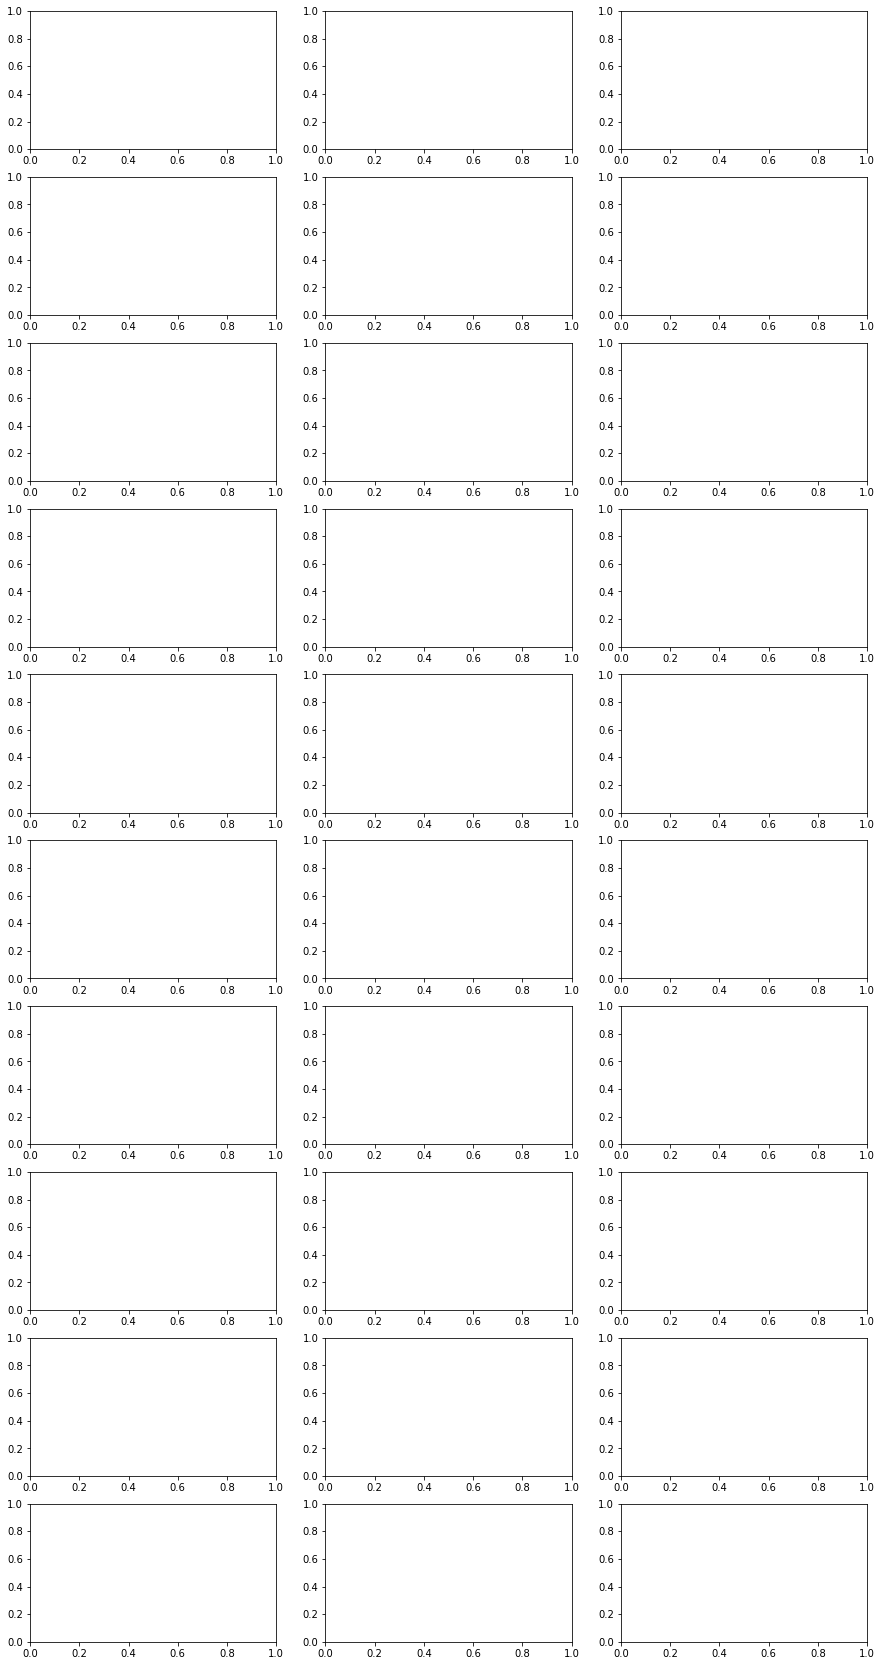

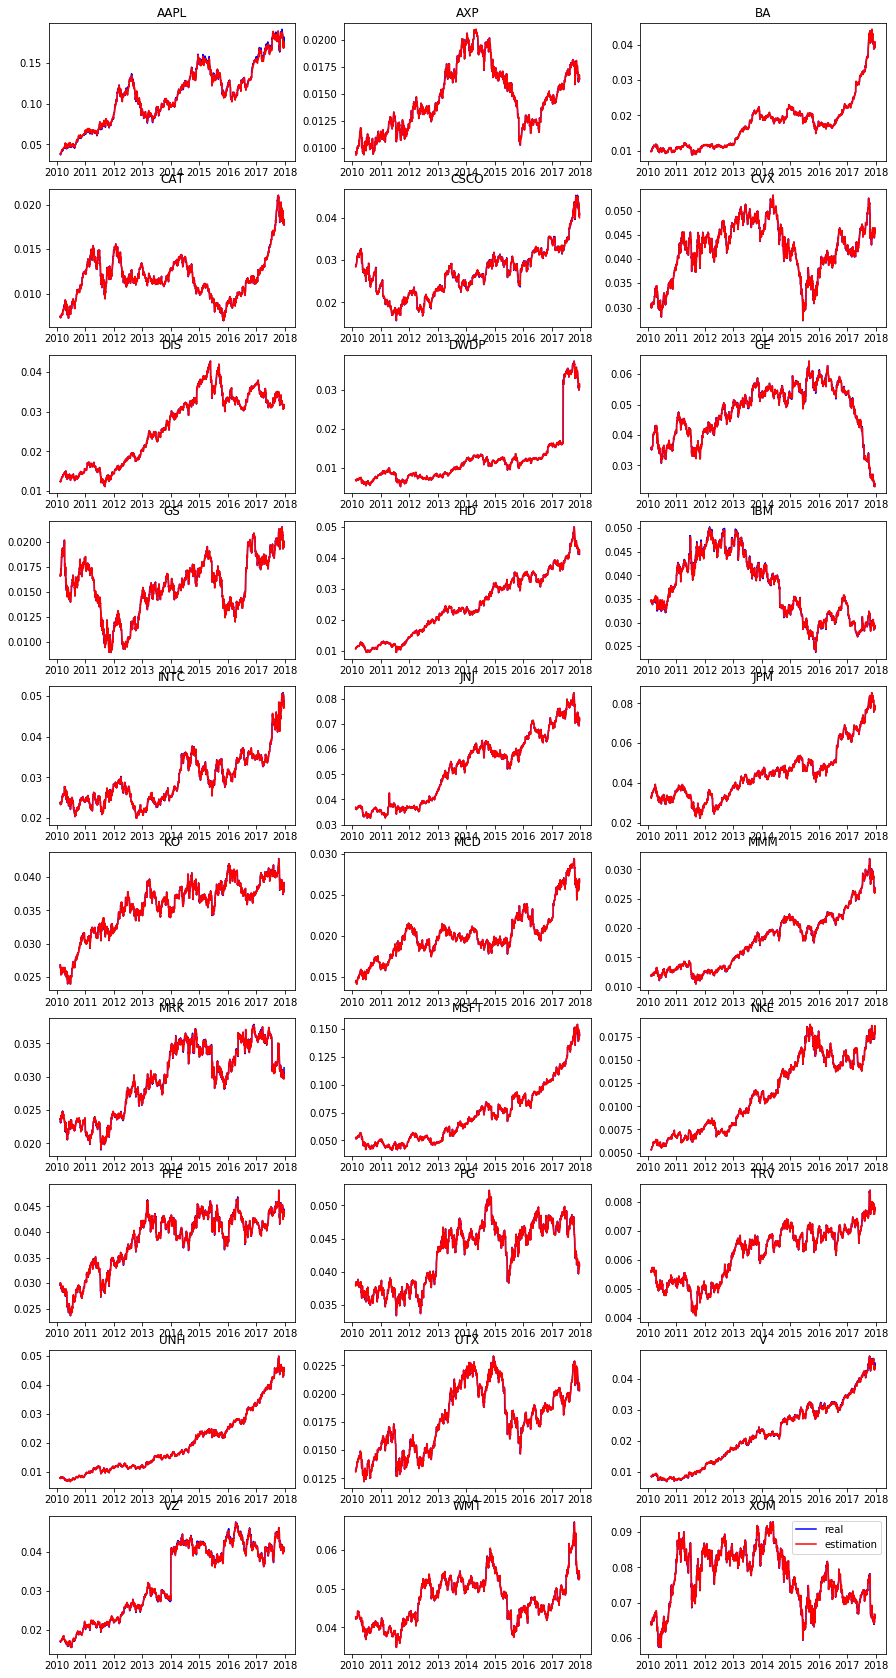

In [60]:
row = 0
col = 0

fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(15, 30))
plt.title("Showing {} stock".format(n), fontsize=12)
for fld in X_next.columns:
    # plt.rcParams["figure.figsize"] = (20,10)
    ax[row][col].plot(X.index, X_next[fld], label="real", color="blue")
    ax[row][col].plot(X.index, X_hat[fld], label="estimation", color="red")
    ax[row][col].set_title(fld)
    col = (col+1)%3
    row=  row+1 if col%3 == 0 else row
plt.legend()
plt.show()

In [62]:
long_ewma_average_first_valid = (long_ewma_average / long_ewma_average.loc[long_ewma_average.first_valid_index()])
long_ewma_average_first_valid

NameError: name 'long_ewma_average' is not defined

In [63]:
short_ewma_demeaned = short_ewma_average_first_valid.pct_change(periods=1).shift(-1)
short_ewma_demeaned

NameError: name 'short_ewma_average_first_valid' is not defined

In [64]:
long_ewma_demeaned = long_ewma_average_first_valid.pct_change(periods=1).shift(-1)
long_ewma_demeaned

NameError: name 'long_ewma_average_first_valid' is not defined

# Clean data

In [65]:
# Put the rest of your code and analysis for Part 3 here.
sp500_dataframe = pd.read_csv("spx_holdings_and_spx_closeprice.csv", index_col=0)

FileNotFoundError: File b'spx_holdings_and_spx_closeprice.csv' does not exist

In [66]:
sp500_dataframe.index.max()

NameError: name 'sp500_dataframe' is not defined

In [67]:
sp500_dataframe_clean = sp500_dataframe.dropna()

NameError: name 'sp500_dataframe' is not defined

In [68]:
sp500_dataframe_clean.shape

NameError: name 'sp500_dataframe_clean' is not defined

In [70]:
from scipy.stats import linregress

def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, _, r_value, _, _ = linregress(x,y)
    return slope

window_1 = 10

short_rolling_regre_sp500 = sp500_dataframe_clean.rolling(window=window_1).apply(get_slope)
window_2 = 30

long_rolling_regre_sp500 = sp500_dataframe_clean.rolling(window=window_2)

NameError: name 'sp500_dataframe_clean' is not defined

# 

In [ ]:
max(short_rolling_regre_sp500[short_rolling_regre_sp500.isnull().any(axis=1) == False].index.min(), long_rolling_regre_sp500[long_rolling_regre_sp500.isnull().any(axis=1) == False].index.min())

In [ ]:
sp500_dataframe_clean.index

In [ ]:
X.shape

In [ ]:
import datetime as dt
start_date = str(dt.date(2000, 3, 9))
end_date = str(dt.date(2013, 12, 20))
test_rows = 300


dataframe_to_seek = sp500_dataframe_clean.loc[ start_date : end_date ].iloc[:-1,:]
next_value = sp500_dataframe_clean.loc[ start_date : end_date ].shift(-1).iloc[:-1,:]
norm_data_fn =  lambda dataframe:  (dataframe)/sp500_dataframe_clean.sum(axis=1).mean()
norm_regre_fn = lambda dataframe: (dataframe - dataframe.mean())/dataframe.std()
zp_1 = norm_regre_fn(short_rolling_regre_sp500).loc[ start_date : end_date ].iloc[:-1,:]
zp_2 = norm_regre_fn(long_rolling_regre_sp500).loc[ start_date : end_date ].iloc[:-1,:]

X_next_full = norm_data_fn(next_value)
X_full = norm_data_fn(dataframe_to_seek)

Z_full = pd.merge(zp_1, zp_2, left_index=True, right_index=True)

X_next = X_next_full.iloc[:-test_rows,:]
X = X_full.iloc[:-test_rows,:]
Z = Z_full.iloc[:-test_rows,:]


X_next_test = X_next.iloc[-test_rows:,:]
X_test = X_full.iloc[-test_rows:,:]
Z_test = Z_full.iloc[-test_rows:,:]

In [ ]:
print(X.shape,X_next.shape, Z.shape)

In [ ]:
sp500_net = net_irl(num_estimators=Z.shape[1], num_stocks=X.shape[1])

In [ ]:
min_error_ths_improvement = 1e-10
losses = []
step = 0
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    loss = sess.run(sp500_net.negative_loglike
                                 ,
                             feed_dict={
                                 sp500_net.X: X.values,
                                 sp500_net.Z: Z.values,
                                 sp500_net.X_plus1: X_next.values})
    losses.append(loss)
    while True:
        step+=1
        _ = sess.run(sp500_net.train
                                     ,
                                 feed_dict={
                                     sp500_net.X: X.values,
                                     sp500_net.Z: Z.values,
                                     sp500_net.X_plus1: X_next.values})
        loss, error, v_t = sess.run([sp500_net.negative_loglike, sp500_net.mse_error_estimation, sp500_net.v_t_reducemean]
                                     ,
                                 feed_dict={
                                     sp500_net.X: X.values,
                                     sp500_net.Z: Z.values,
                                     sp500_net.X_plus1: X_next.values})
        losses.append(loss)
        if(step%1000 == 0):
            print("step {} - LOSS:{}  ERROR:{}  V_T:{}".format(step, loss, error, v_t))
        if(losses ==np.nan):
            print("Nan found. stop trainnning")
            break;
        if(np.abs(losses[-1]-losses[-2])<=min_error_ths_improvement):
            print("Threshold found finishing trainning and saving")
            save_path = saver.save(sess, "models/sp500_model.ckpt")
            break;

In [ ]:
tf.reset_default_graph()
sp500_net = net_irl(num_estimators=Z.shape[1], num_stocks=X.shape[1])

saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Restore variables from disk.
    saver.restore(sess, "models/sp500_model.ckpt")
  
    w0, W, speed_k, sigma, theta, v_t_hat = sess.run([
                                    sp500_net.w0,
                                  sp500_net.W,
                                sp500_net.speed_k,
                                sp500_net.sigma,
                                sp500_net.theta,

                                sp500_net.v_t_hat
                                 ],
                             feed_dict={
                                 sp500_net.X: X_test.values,
                                 sp500_net.Z: Z_test.values})

In [ ]:
params_df = pd.DataFrame(index = X.columns)
params_df["k"] = speed_k
params_df["sigma"] = sigma
params_df["w0"] = w0
for w_i in range(W.shape[1]):
    params_df["w{}".format(w_i+1)] = W[:,w_i]
params_df.to_csv("params_tunning_sp500.csv")

In [ ]:
estimation_df = pd.DataFrame(v_t_hat, index=X_test.index, columns=X_test.columns)

In [ ]:
X_hat = (estimation_df * X_test) + X_test

In [ ]:
row = 0
col = 0

fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 9))
plt.title("Showing {} stock".format(stock_name), fontsize = 12)
for fld in X_next_test.columns[-9:]:
    # plt.rcParams["figure.figsize"] = (20,10)
    ax[row][col].plot(X_next_test.index, X_next_test[fld], label = "real", color = "blue")
    ax[row][col].plot(X_next_test.index, X_hat[fld], label = "estimation", color = "red")
    ax[row][col].set_title(fld)
    col = (col + 1)%3
    row =  row + 1 if col%3 == 0 else row
plt.legend()
plt.show()

## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=30)
pca.fit(Z_full.values)
Z_full_pca = pd.DataFrame(pca.transform(Z_full.values), index=Z_full.index, columns = ["pca{}".format(x) for x in range(30)])
Z = Z_full_pca.iloc[:-test_rows,:]
Z_test = Z_full_pca.iloc[-test_rows:,:]

In [ ]:
# Put the rest of your code and analysis for Part 3 here.
sp500_dataframe = pd.read_csv("spx_holdings_and_spx_closeprice.csv", index_col=0)

In [ ]:

min_error_ths_improvement = 1e-10
losses = []
step = 0
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    loss = sess.run(sp500_pca_net.negative_loglike
                                 ,
                             feed_dict={
                                 sp500_pca_net.X: X.values,
                                 sp500_pca_net.Z: Z.values,
                                 sp500_pca_net.X_plus1: X_next.values})
    losses.append(loss)
    while True:
        step+=1
        _ = sess.run(sp500_pca_net.train
                                     ,
                                 feed_dict={
                                     sp500_pca_net.X: X.values,
                                     sp500_pca_net.Z: Z.values,
                                     sp500_pca_net.X_plus1: X_next.values})
        loss, error, v_t = sess.run([sp500_pca_net.negative_loglike, sp500_pca_net.mse_error_estimation, sp500_pca_net.v_t_reducemean]
                                     ,
                                 feed_dict={
                                     sp500_pca_net.X: X.values,
                                     sp500_pca_net.Z: Z.values,
                                     sp500_pca_net.X_plus1: X_next.values})
        losses.append(loss)
        if(step%1000 == 0):
            print("step {} - LOSS:{}  ERROR:{}  V_T:{}".format(step, loss, error, v_t))
        if(losses ==np.nan):
            print("Nan found. stop trainnning")
            break;
        if(np.abs(losses[-1]-losses[-2])<=min_error_ths_improvement):
            print("Threshold found finishing trainning and saving")
            save_path = saver.save(sess, "models/sp500_pca_model.ckpt")
            break;
        

In [ ]:
tf.reset_default_graph()
sp500_pca_net = net_irl(num_estimators=Z.shape[1], num_stocks=X.shape[1])
saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Restore variables from disk.
    saver.restore(sess, "models/sp500_pca_model.ckpt")
  
    w0, W, speed_k, sigma, theta, v_t_hat = sess.run([
                                    sp500_pca_net.w0,
                                  sp500_pca_net.W,
                                sp500_pca_net.speed_k,
                                sp500_pca_net.sigma,
                                sp500_pca_net.theta,

                                sp500_pca_net.v_t_hat
                                 ],
                             feed_dict={
                                 sp500_pca_net.X: X_test.values,
                                 sp500_pca_net.Z: Z_test.values})

In [ ]:
params_df = pd.DataFrame(index = X.columns)
params_df["k"] = speed_k
params_df["sigma"] = sigma
params_df["w0"] = w0
for w_i in range(W.shape[1]):
    params_df["w{}".format(w_i+1)] = W[:,w_i]
params_df.to_csv("params_tunning_sp500_pca.csv")

In [ ]:
estimation_df = pd.DataFrame(v_t_hat, index=X_test.index, columns=X_test.columns)

In [ ]:
X_hat = (estimation_df*X_test)+X_test

In [ ]:
row = 0
col = 0

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
plt.title("Showing {} stock".format(stock_name), fontsize=12)
for fld in X_next_test.columns[-9:]:
    # plt.rcParams["figure.figsize"] = (20,10)
    ax[row][col].plot(X_next_test.index, X_next_test[fld], label="real", color="blue")
    ax[row][col].plot(X_next_test.index, X_hat[fld], label="estimation", color="red")
    ax[row][col].set_title(fld)
    col = (col+1)%3
    row=  row+1 if col%3 == 0 else row
plt.legend()
plt.show()

## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [ ]:
# Put the rest of your code and analysis for Part 3 here.